**PROBLEM ONE**

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate as interp
from scipy import integrate 
from scipy import stats 
from tqdm import tqdm
# from mpl_toolkit.mplot3d import Axes.3D
import time
from IPython.display import display, Latex
%matplotlib notebook

def adj_subplots(): #little function to adjust subplots 
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)



Note that Loic Miara and myself worked together on the reasoning of this assignment such that they might look similar, but we both made our codes and explanations by ourselves.

**PROBLEM ONE**

*RK4 STEPPER*: * These explanations are based on the *Numerical Recipes* textbook and John's notes

The idea of the Runge-Kutta method for ODE integration is to "improve" the Euler step method (having $O(h^2)$ error for step size h) by taking "trial" step(s) within the step interval as to obtain "more accurate" derivative information (instead of using the first point only to evaluate the derivative). RK2 (i.e. second order Runge-Kutta) uses the midpoint x and y values to compute the step across the interval: this cancels the first Euler term such that RK2 is a second order method, $O(h^3)$ error. The fourth order Runge-Kutta method (RK4) takes the idea further by evaluating the derivative four times (twice at the middle point and at each end points) leaving a $O(h^5)$ error term as follows:

$k_1=hf(x_n,y_n)$<br>
$k_2=hf(x_n+\frac{h}{2},y_n+\frac{k_1}{2})$<br>
$k_3=hf(x_n+\frac{h}{2},y_n+\frac{k_2}{2})$<br>
$k_4=hf(x_n+h,y_n+k3)$<br>
$y_{n+1}=y_n+\frac{k_1}{6}+\frac{k_2}{3}+\frac{k_3}{3}+\frac{k_4}{6}+O(h^5)$<br>

Thus, RK4 makes four function evaluations and we can write $y(x+2h)=y_1+(2h)^5\phi+O(h^6)$ (1) where 2h is the step, $y_1$ is the computed step (i.e. $y_{n+1}$) and $\phi$ is a Taylor-series expansion term (independent of $h$).<br>
$\implies$*rk4_step( ) implements the above method*

$\implies$*rk4_stepd( ) implements the method below*<br>
*The following explanations/derivations are according to the textbook Numerical Derivatives: Section Adaptive Stepsize Control for Runge-Kutta*  *<br>
Now, as to increase the accuracy of the method, the stepsize can be varied (while we note that h should neither be too large nor too small). Here, three RK4's are performed, one with a full h step and two with h/2 steps which is called step doubling. The two step RK4 approximation is compared with the one step RK4 approximation and the comparison is used to reduce the error term order by one. 

Let $x_0,y_0$ be the initial point, $2h$ be the one step length and $y_t$ be the point aimed to be approximated (corresponding to $f(x+h)$). The first $h$ step is:<br>
$y(x+h)=y_m+h^5\phi+O(h^6)$, where $y_m$ is the half-step RK4 approximated mid-interval point (at $x_m=x+h$). Then, the second step is performed from $(x_m,y_m)$ to $x+h$ such that $y(x_m+h)=y_2+h^5\phi+O(h^6)$ where $y_2$ is the second step RK4 approximation of $y_t$. Summing the errors of the two half steps, we have that the combination of the RK4 steps is $y(x+2h)=y_2+2h^5\phi+O(h^6)$.

To estimate the truncation error, we take the difference of the two approximations of $y_t$ (i.e, $y_1$ and $y_2$):<br>
$y_2-y_1 = y(x+2h)-2h^5\phi+O(h^6)-y(x+2h)+(2h)^5\phi+O(h^6)=32h^5\phi-2h^5\phi+O(h^6)=30h^2\phi+O(h^6)$<br>
$\implies 2h^5\phi=\frac{y_2-y_1}{15}$<br>
Therefore, we can truncate the $h^5$ error term by evaluating the step as, $y(x+2h)=y_2-\frac{y_2-y_1}{15}+O(h^6)$ such that we have a step doubling Runge-Kutta method with a seventh-order error term (i.e. $O(h^6)$).

Since this RK4 step doubling requires performing 3 RK4 (two half step and one full step), we have 12 function evaluations per step taken. However, since $k1$ evaluates the derivative at the same initial point, $(x_n,y_n)$, for the first half step ($x+h$) and the full step ($x+2h$), this evaluation can be re-used such that we have a total of 11 function evaluations.




<IPython.core.display.Javascript object>


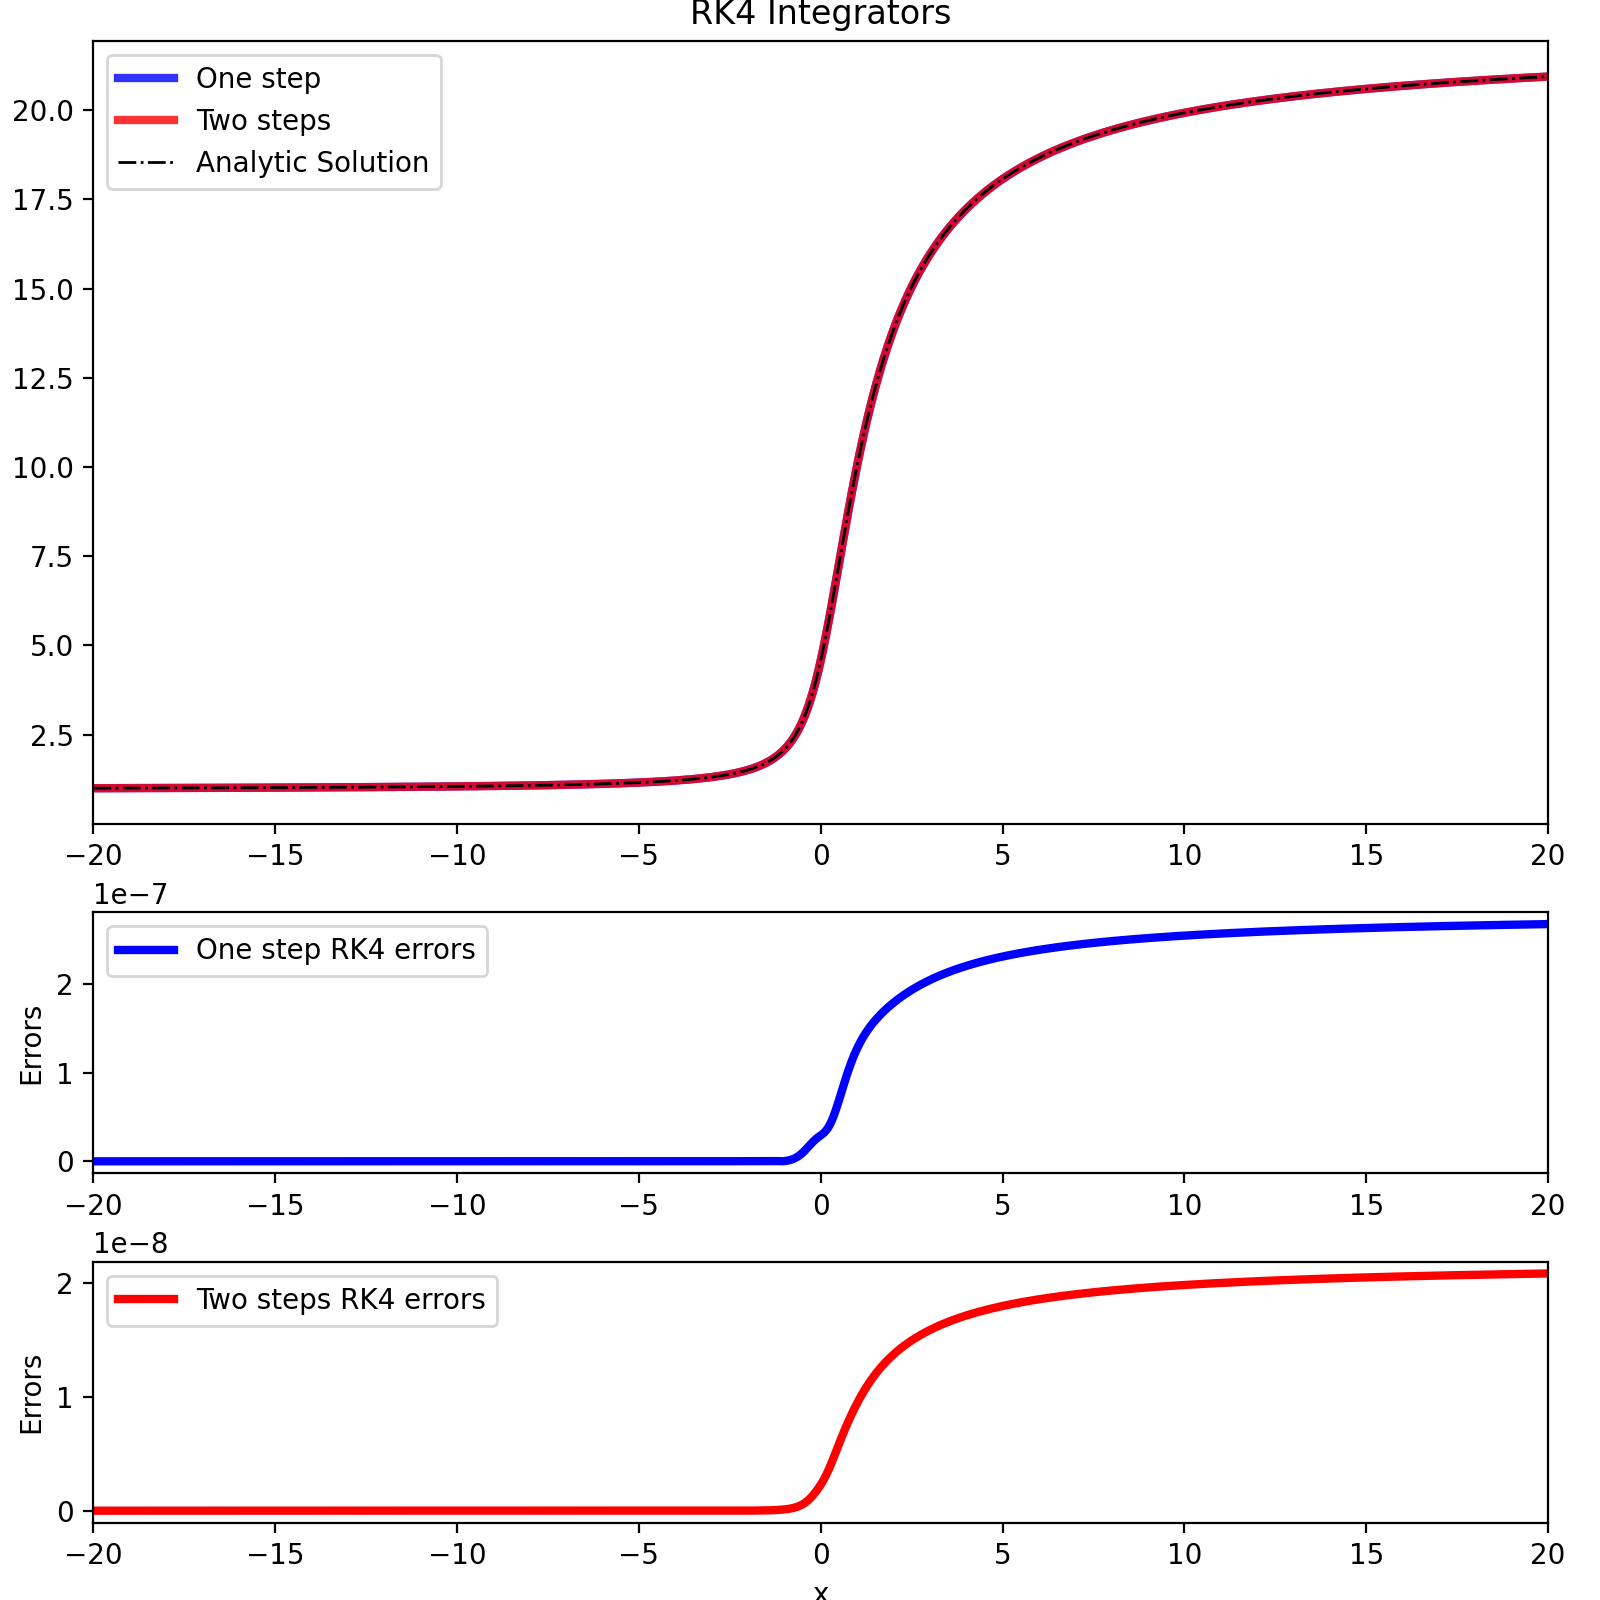

In [12]:
#Re-used John's RK4 code
def odefun(x,y): #Ode function
    dydx = y/(1+x**2)
    return dydx

def rk4_step(fun,x,y,h,k1=None,returnk1=False):
    if k1 is None: #if not already evaluated (i.e. when rk4_step is called in rk4_stepd)
        k1=fun(x,y)*h
        
    k2=h*fun(x+h/2,y+k1/2)
    k3=h*fun(x+h/2,y+k2/2)
    k4=h*fun(x+h,y+k3)
    dy=(k1+2*k2+2*k3+k4)/6
    
    if returnk1:
        return y+dy, k1 #return k1 so to not evaluate the function twice in 2 step method
    
    return y+dy 

def rk4_stepd(fun,x,y,h):
    #Big step:
    y_h,k1 = rk4_step(fun,x,y,h,returnk1=True)
    #adjust k1 for half step
    k1_adj=k1/2

    #First small step:
    y_mid = rk4_step(fun,x,y,h/2,k1=k1_adj)
    #Second big step:
    y_2h = rk4_step(fun,x+h/2,y_mid,h/2)
    
    #Compare the two
    compare = y_h-y_2h
    
    #Make adjustment to cancel the error
    y_2step =  y_2h-compare/15
    
    return y_2step

#Analytic Solution
def analytic_fun(x,x0):
    c0 = np.exp(-np.arctan(x0))
    return c0*np.exp(np.arctan(x))

#Testing
def evaluate(method,odefun,x_range,y0,numeval):
    #method 1 => one step
    #method 2 => 2 step
    if method == 1:
        rkfun = rk4_step
        numsteps = 4 #number of function evaluations per step
    else:
        rkfun = rk4_stepd
        numsteps = 11 #number of function evaluations per step
        
    numpts = int(numeval/numsteps) #this way, both function will have the same number of function evaluations
    x=np.linspace(x_range[0],x_range[1],numpts)
    h=np.median(np.diff(x))
    y=np.zeros(len(x))
    y[0]=y0 #initial value
        
    for i in range(len(x)-1):
        y[i+1]=rkfun(odefun,x[i],y[i],h) #perfom rk4 for each x points that we want to step 
    return y,x


#Plotting the rk4s
x_range=[-20,20]
y0=1
y_2h,x_2h = evaluate(1,odefun,x_range,1,4400)
y_2htrue = analytic_fun(x_2h,x_2h[0])
y_h,x_h = evaluate(2,odefun,x_range,1,4400)
y_htrue = analytic_fun(x_h,x_h[0])

fig,axs=plt.subplots(3,figsize=([8,8]),gridspec_kw={'height_ratios':[3,1,1]})  
fig.tight_layout()
axs[0].plot(x_2h,y_2h,color='blue',alpha=0.8,label='One step',linewidth=3)
axs[0].plot(x_h,y_h,color='red',alpha=0.8,label='Two steps',linewidth=3)
axs[0].plot(x_2h,y_2htrue,color='k',linestyle='-.',label='Analytic Solution',linewidth=1)
axs[0].set_title('RK4 Integrators')
axs[0].set_ylabel('Function Approximation')
axs[0].set_xlim(-20,20)
axs[0].legend()

axs[1].plot(x_2h,np.abs(y_2htrue-y_2h),color='blue',linewidth=3,label='One step RK4 errors')
axs[1].set_ylabel('Errors')
axs[1].set_xlim(-20,20)
axs[1].legend()


axs[2].plot(x_h,np.abs(y_htrue-y_h),color='red',linewidth=3,label='Two steps RK4 errors')
axs[2].set_ylabel('Errors')
axs[2].set_xlabel('x')
axs[2].set_xlim(-20,20)
axs[2].legend()



plt.show()




As expected, for the same number of function evaluations, the step doubling RK4 is more accurate by one order as the errors are one order lower than the errors for the non-modified stepper method (full step RK4).

**PROBLEM 2**

a)

We can solve the radioactive decay products with a set of coupled ODE equations. A radioactive element decays exponentially; knowing its half-life we can write the decay rate as $\frac{dy}{dt}=\frac{-y_0}{t_{1/2}}$ where $y_0$ is the initial quantity and $t_{1/2}$ its half-life. For a decaying "chain" of radioactive element, the net decay rate of the element $e_n$ is the difference of the decay rate of its parent element ($e_{n-1}$) and its own decay rate. Hence, we have a set a coupled ODEs that can be written as follows:<br>
$(\frac{dy}{dt})_{e_0}=-(\frac{y_0}{t_{1/2}})_{e_0}$<br>
$(\frac{dy}{dt})_{e_1}=(\frac{y_0}{t_{1/2}})_{e_0}-(\frac{y_0}{t_{1/2}})_{e_1}$<br>
$\vdots$<br>
$(\frac{dy}{dt})_{e_{n-1}}=(\frac{y_0}{t_{1/2}})_{e_{n-2}}-(\frac{y_0}{t_{1/2}})_{e_{n-1}}$<br>
$(\frac{dy}{dt})_{e_n}=(\frac{y_0}{t_{1/2}})_{e_{n-1}}$<br>
The half lives of the Uranium 238 decay chain differ greatly, scailing from billions of years (U238) to microseconds (Po214) such that we have a stiff system. The code below solves for the U238 decay products, defined as a system of ODEs in the form described above and uses scipy's integrate solve_IVP which numerically integrates a system of ordinary differential equations given an initial value. We use the "Radau" method which is recommended for stiff problems (which is the case here).

<IPython.core.display.Javascript object>


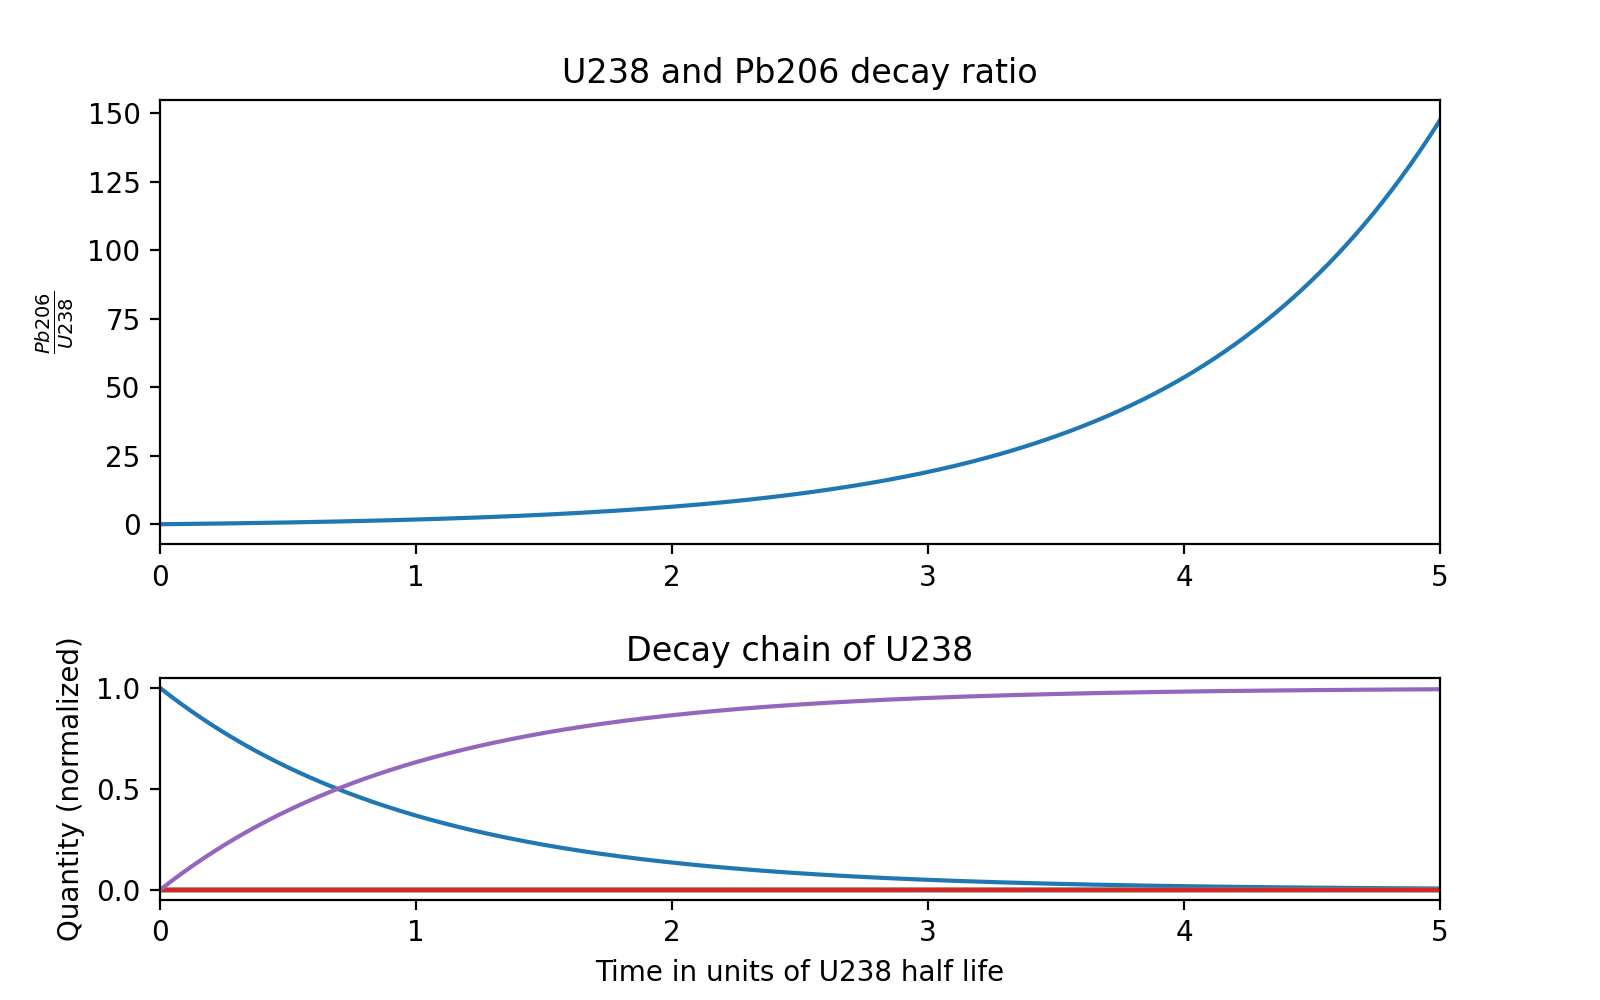

(0.0, 5.0)

In [13]:
#Loïc sent me this small part
years = 365*24*60*60
days = years/365
hours = days/24
minutes = hours/60

half_lives = np.array([4.468e9*years, 24.1*days,6.7*hours,245.5e3*years,75.38e3*years,1600*years,
             3.8235*days,3.1*minutes,26.8*minutes,19.9*minutes,164.3e-6,22.3*years,5.015*years,
             138.376*days])
half_lives_norm = half_lives/np.max(half_lives)#normalize the half lives to have the time in units of U238 t_1/2
#end of Loïc's code block

#Inspired from John's code
def decay(x,y,half_lives=half_lives_norm):
    
    #ode system described above
    dydx=np.zeros(len(half_lives)+1)
    dydx[0]=-y[0]/half_lives[0]
    for i in range(1,len(half_lives)):
        dydx[i]=y[i-1]/half_lives_norm[i-1] - y[i]/half_lives_norm[i]
    dydx[i+1] = y[i-1]/half_lives_norm[i-1]
    
    return dydx

t_span = [0,5] #time spans from 0 to 5 half lifes of U238
t_array = np.linspace(t_span[0],t_span[1],1001)
y_0 = np.zeros(len(half_lives_norm)+1)
y_0[0] = 1 #normalize the initial value of U238 to 1


stiff_ans = integrate.solve_ivp(decay,t_span,y_0,method='Radau',t_eval=t_array) #solve odes with scipy
pb206 = stiff_ans.y[-1] #solution for Pb206
u238 = stiff_ans.y[0] #solution for U238

#Plot the ration of Pb206 to U238
fig,axs=plt.subplots(2,figsize=([8,5]),gridspec_kw={'height_ratios':[2,1]}) 
adj_subplots()
axs[0].plot(stiff_ans.t,pb206/u238)
axs[0].set_title('U238 and Pb206 decay ratio')
axs[0].set_ylabel(r'$\frac{Pb206}{U238}$')
axs[0].set_xlim([0,5])

#Plot all solutions
for i in range(len(half_lives)+1):
    axs[1].plot(stiff_ans.t,stiff_ans.y[i])
axs[1].set_title('Decay chain of U238')
axs[1].set_xlabel('Time in units of U238 half life')
axs[1].set_ylabel('Quantity (normalized)')
axs[1].set_xlim([0,5])


The exponentially increasing curve of the Pb206 to U238 ratio makes sense as the amount U238 products goes to zero as $t>>t_{1/2,U238}$ and all products decay into Pb206 such that $lim_{t\rightarrow \infty}\frac{Pb206}{U238}=\infty$. We can also observe on the decay chain plot how the curves of the other elements (i.e. not Pb206 and U238) seem to be constant and null compared to the U238 decrease and Pb206 increase. This is also expected as their half-lives scale between years and microseconds such that their decay is not perceptible in U238's half life unit of time. In fact, once one U238 product decays into Thorium-234, it takes a some years for the sub-products to ultimately decay into Pb206 which is about "nothing" compared to the amount of time for other U238 products to decay. Hence, we don't perceive the "wiggles" of the decay curves of these elements on this plot even though they are there.

<IPython.core.display.Javascript object>


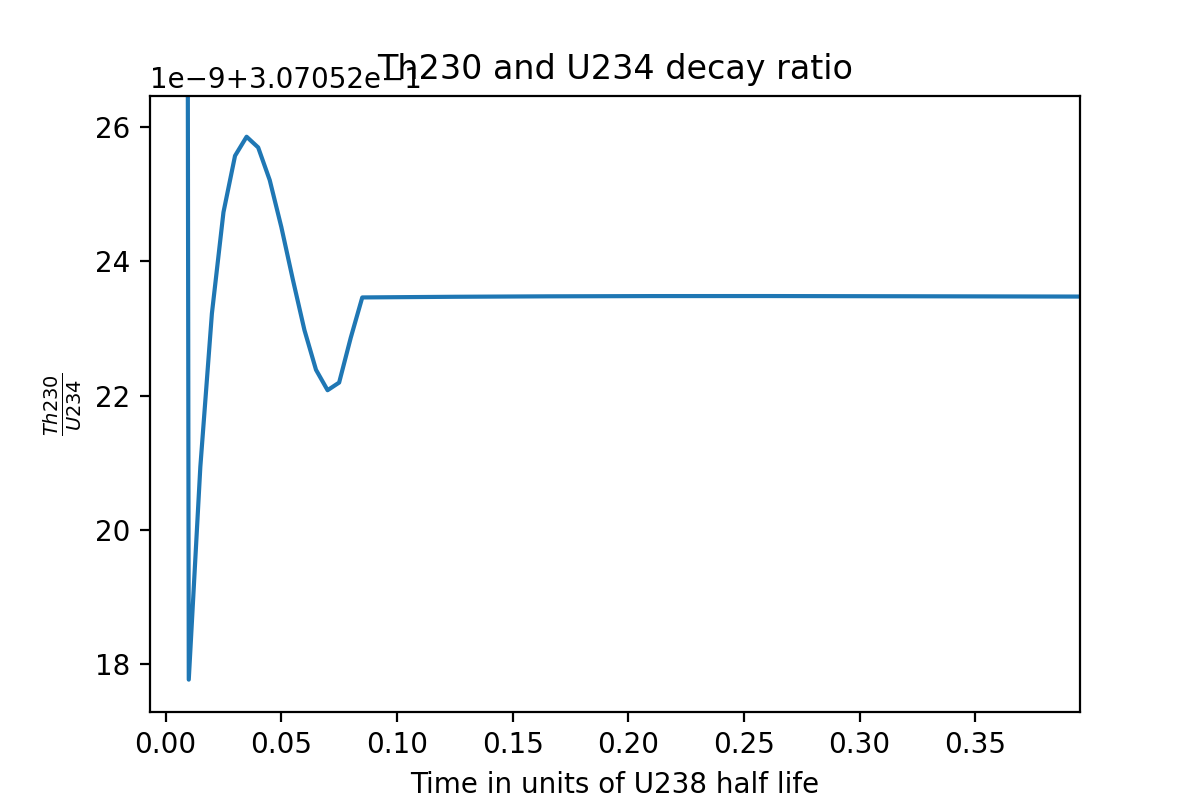

Text(0.5, 0, 'Time in units of U238 half life')

In [14]:
th230 = stiff_ans.y[4][1:] #Th230 solution
u234 = stiff_ans.y[3][1:] #U234 solution
#plot the ratio
plt.figure(figsize=[6,4])
plt.plot(stiff_ans.t[1:],th230/u234)
plt.title('Th230 and U234 decay ratio')
plt.ylabel(r'$\frac{Th230}{U234}$')
plt.xlabel('Time in units of U238 half life')


It makes sense analytically that a few wiggles are present at the "beginning" of U238 decay (i.e. 0-0.1 of U238 half time) as it represents the transcient part which is expected for ODE solutions. The Thorium 230 to Uranium 234 ratio stabilizes to a secular equilibrium which represents the stable part of the solution. U234 and Th230 have half lives significant compared to our life time scale (245,500 and 75,380 years respectively) but very small compared to U238 (4,468 billions of years). This makes it possible to estimate an "age" that can be calculated from the degree to which the secular equilibrium [(i.e. what we see in the stable solution)] has been restored between Th-230 and U-234. 


**PROBLEM 3**

Below is a 3D plot of the photogrammetry data that we have.

<IPython.core.display.Javascript object>


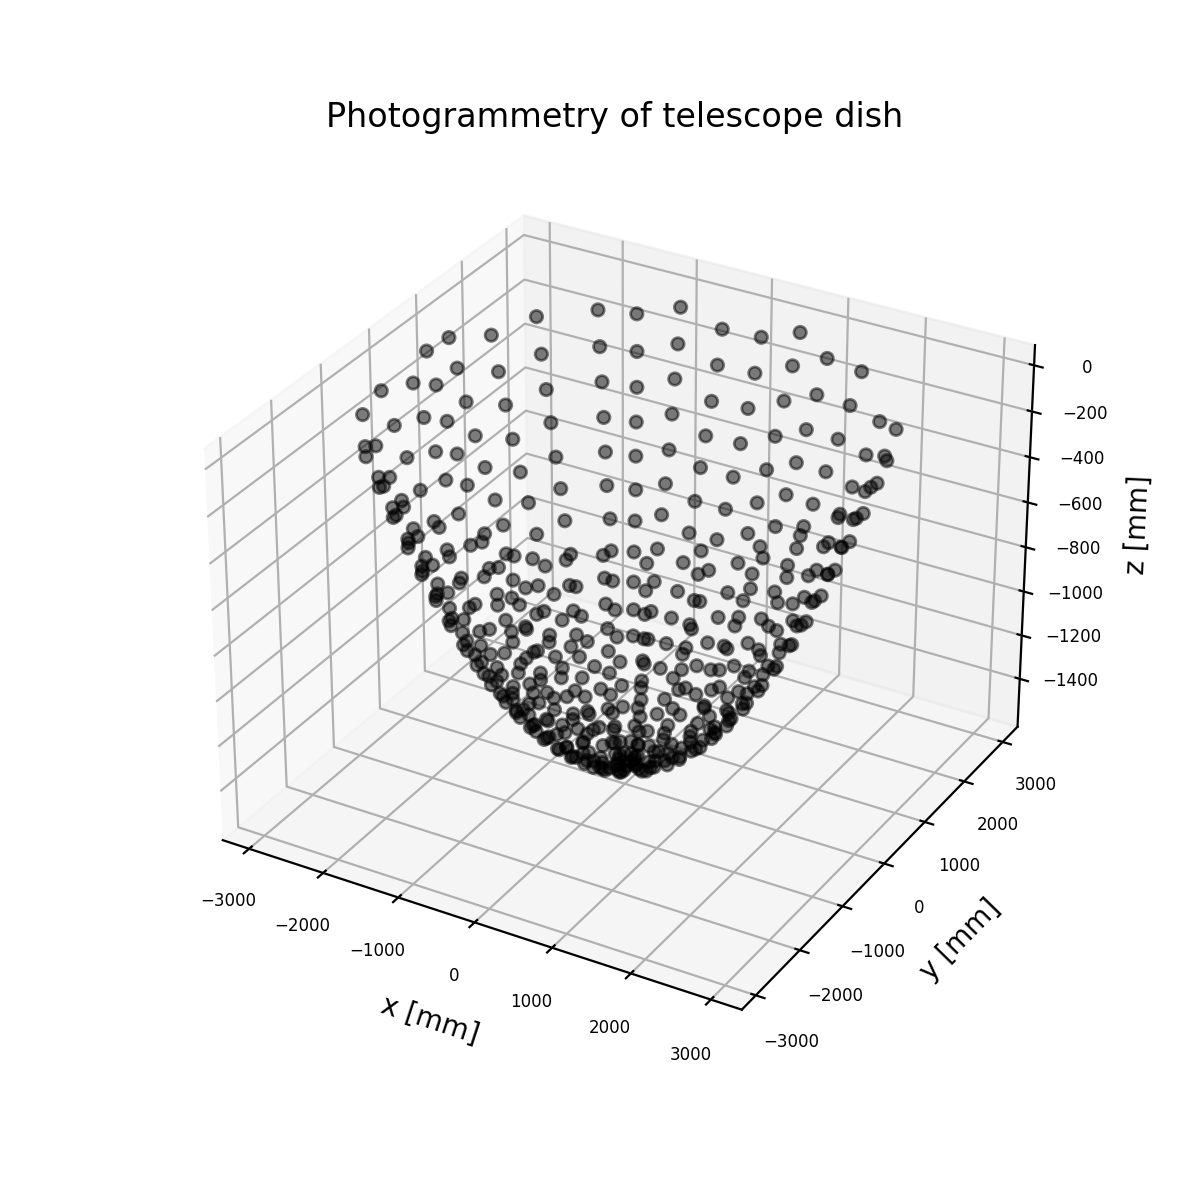

In [15]:
dish = np.loadtxt('dish_zenith.txt') #data
#plot the data
fig = plt.figure(figsize=[6,6])
ax = plt.axes(projection='3d')
ax.scatter3D(dish[:,0], dish[:,1], dish[:,2],marker='o',color='black',alpha=0.5)
ax.set_title('Photogrammetry of telescope dish')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
ax.tick_params(axis='both', which='major', labelsize=6)

a)

The equation of a symmetric paraboloid is $z=a((x-x_0)^2+(y-y_0)^2)+z_0$ and we want to do a linear least-squares fit on the dish data: the parameters to fit are $a,x_0,y_0$ and $z_0$. Simple algebra can be done to simplify this equation in a linear form with a new set of parameters:<br><br>
 $z=a((x-x_0)^2+(y-y_0)^2)+z_0=ax^2-2axx_0+ax_0^2+ay^2-2ayy_0+ay_0^2+z_0$<br>
 $=a(x^2+y^2)-2ax_0(x)-2ay_0(y)+(ax_0^2+ay_0^2+z_0)=A(x^2+y^2)+B(x)+C(y)+D$, where<br>
 $A=a, B=-2ax_0, C=-2ay_0, D=(ax_0^2+ay_0^2+z_0)$ such that $a=A, x_0=\frac{-B}{2A}, y_0=\frac{-C}{2A}, z_0=D-\frac{B^2}{4A}-\frac{C^2}{4A}$.<br>
 
 So, we can perform a linear least-squares fitting on the equation $z=A(x^2+y^2)+B(x)+C(y)+D$ and recover $a,x_0,y_0$ and $z_0$ from the new $A,B,C,D$ parameters as shown above.

b)

We find the maximum likehood model parameters by minimizing $\chi^2$ which is done by a linear least-squares fit, where least squares is defined as $\chi^2=(x-Am)N^{-1}(x-Am)$ where x is the a vector of the observed data, A the matrix that transforms to predicted values,m the vector of the modelled parameters and N the noise covariance matrix. We minimize $\chi^2$ with respect to $m$ (i.e. take $\frac{\partial \chi^2}{\partial m}=0$ and solve for $m$) which can be written as follows:
$m=(A^TN^{-1}A)^{-1}A^TN^{-1}x$. Since we do not have the noise covariance matrix, we assume that we have noiseless data such that $m=(A^TA)^{-1}A^Tx$, where $m$ will be our returned least-squares fit parameters $A,B,C,D$. Using $A,B,C,D$ to derive $a,x_0,y_0,z_0$ we can plot the modelled paraboloid telescope dish.

Following is a table of the derived best-fit modelled derived parameters



<IPython.core.display.Latex object>

Values:      [0.0001667] [-1.36048862] [58.22147608] [-1512.87721004]
Uncertainty: 1.71e-08        0.0995        0.0951        0.081


Following is a table of the derived best-fit modelled parameters



<IPython.core.display.Latex object>

Values:      0.0001667      0.0004536      -0.019412      -1512.3
Uncertainty: 1.71e-08       3.32e-05       3.16e-05        0.0828


<IPython.core.display.Javascript object>


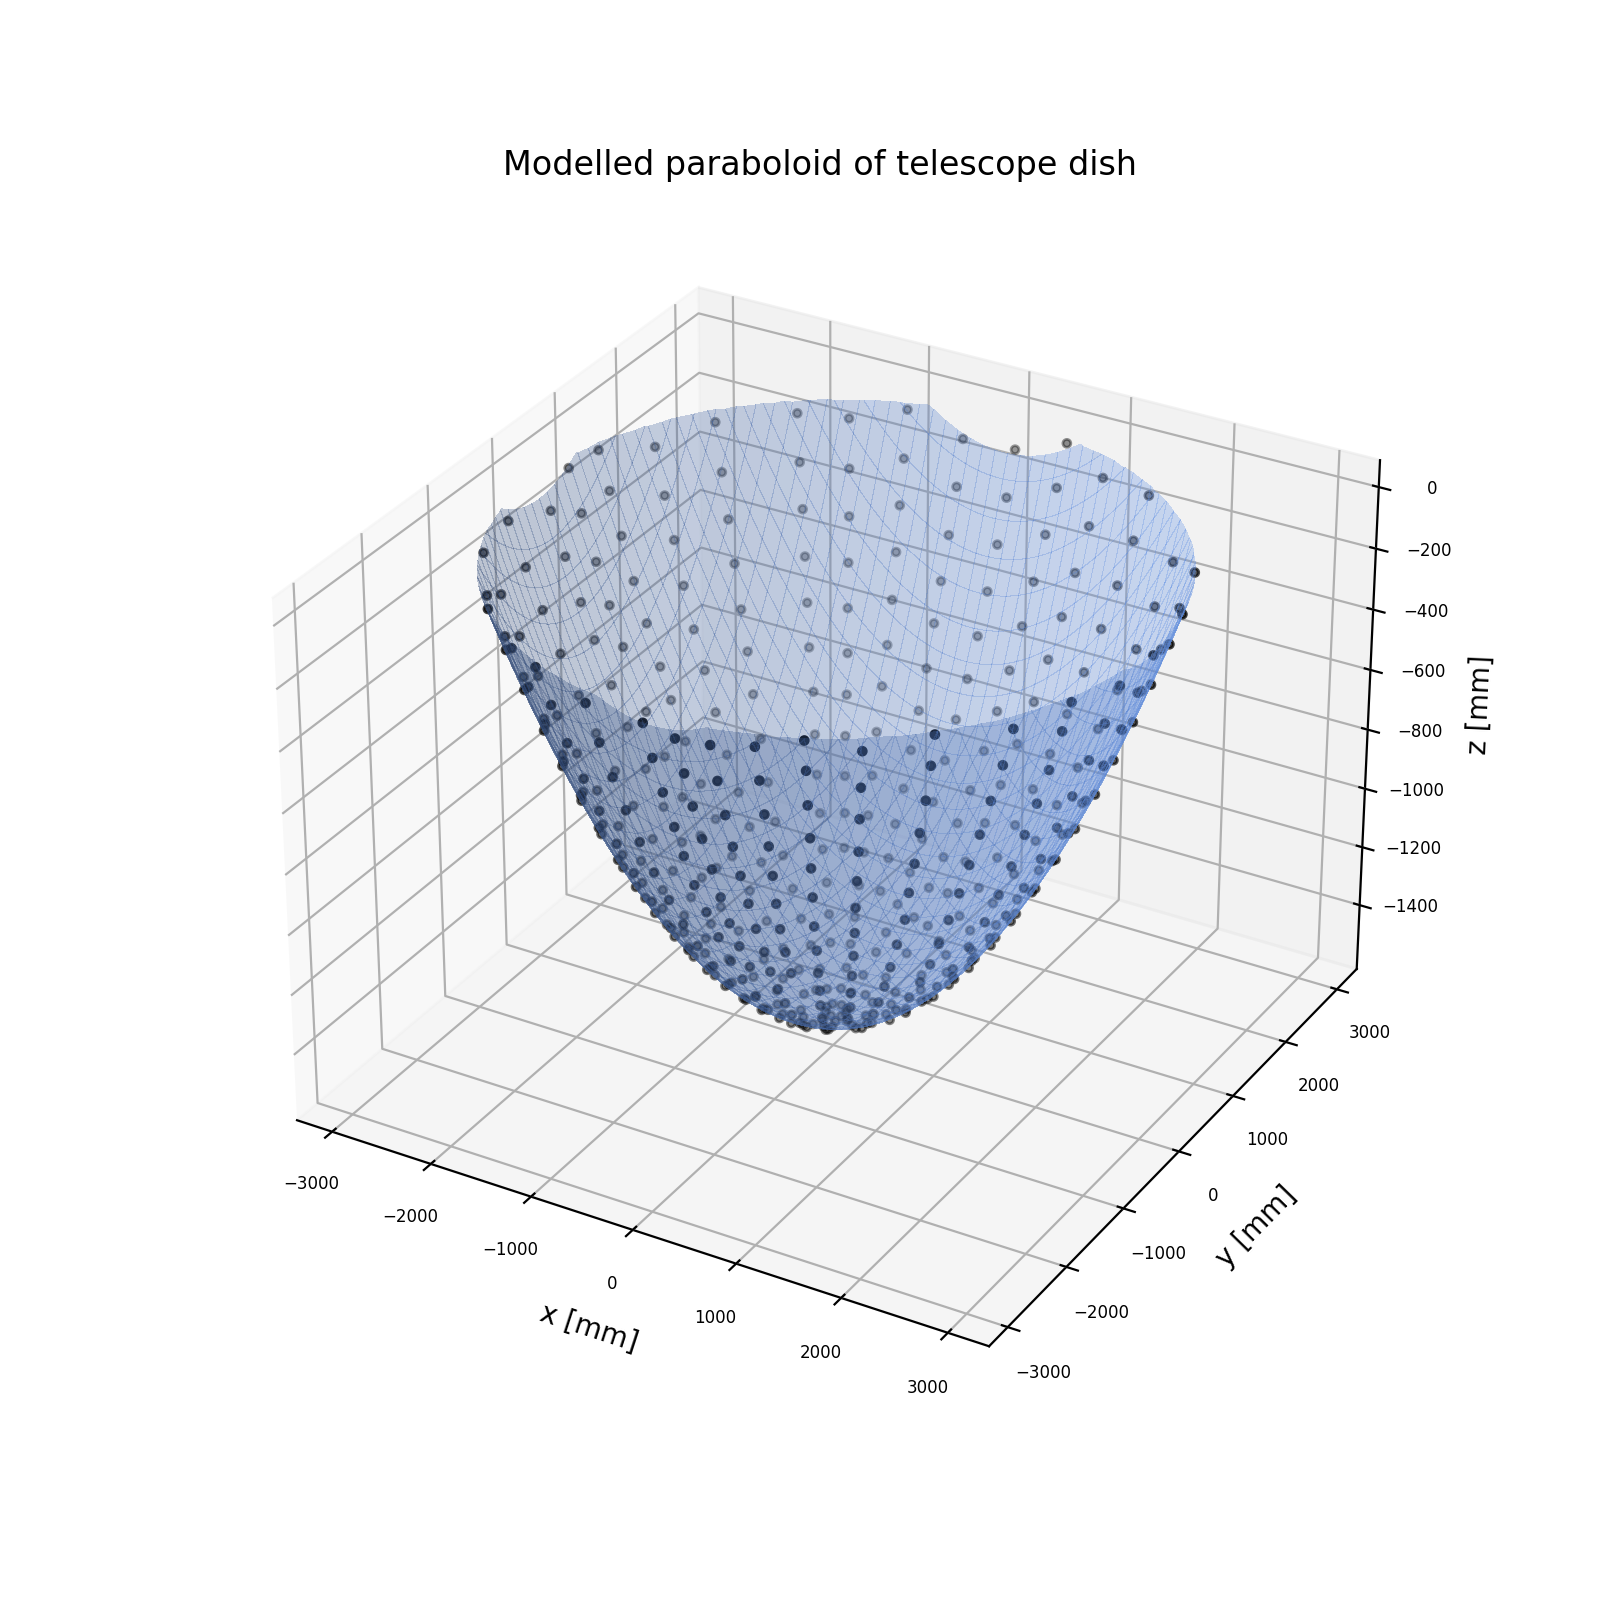

In [16]:
#inspired from John's code
#make the matrices
x_dish=dish[:,0];y_dish=dish[:,1];z_dish=dish[:,2]
M=np.empty([len(z_dish),4])


M[:,0]=x_dish**2+y_dish**2
M[:,1]=x_dish
M[:,2]=y_dish
M[:,3]=1

lhs=M.T@M
rhs=M.T@z_dish
pp=np.linalg.inv(lhs)@rhs


#recover the parameters
params=np.empty([len(pp),1])
params[0]=pp[0]
params[1]=-pp[1]/(2*pp[0])
params[2]=-pp[2]/(2*pp[0])
params[3]=(pp[3]-params[0]*(params[1]**2+params[2]**2))

#calculate the errors/uncertainties
cov=np.sqrt(np.diag(np.linalg.inv(lhs))) #parameters error
err_bar = M@np.linalg.inv(lhs)@M.T #error bars on the predicted data
#propagation of errors
unty=np.zeros([len(cov)])
unty[0]=cov[0]
unty[1]=np.abs(params[1])*np.sqrt((cov[0]/pp[0])**2+(cov[1]/pp[1])**2)
unty[2]=np.abs(params[2])*np.sqrt((cov[0]/pp[0])**2+(cov[2]/pp[2])**2)
unty[3]=cov[3]+(params[3]-pp[3])*np.sqrt((unty[0]/params[0])**2+
                                         ((2*params[1]*unty[1]+2*params[2]*unty[2])/(params[1]**2+params[2]**2))**2)
#print the parameters
print('Following is a table of the derived best-fit modelled derived parameters\n')
display(Latex(f'Parameters:$\qquad a \qquad \qquad \qquad x_0 \qquad \qquad \qquad y_0 \qquad \qquad \qquad z_0 $'))
print('Values:     ',params[0],params[1],params[2],params[3])
print('Uncertainty:',f'{unty[0]:.3}','      ',f'{unty[1]:.3}','      ',f'{unty[2]:.3}','      ',f'{unty[3]:.3}')

print('\n\nFollowing is a table of the derived best-fit modelled parameters\n')
display(Latex(f'Parameters:$\qquad A \qquad \qquad \qquad B \qquad \qquad \qquad C \qquad \qquad \qquad D $'))
print('Values:     ',f'{pp[0]:.5}','    ',f'{pp[1]:.5}','    ',f'{pp[2]:.5}','    ',f'{pp[3]:.5}')
print('Uncertainty:',f'{cov[0]:.3}','     ',f'{cov[1]:.3}','     ',f'{cov[2]:.3}','      ',f'{cov[3]:.3}')
def paraboloid(a,x0,y0,z0,x,y):
    return a*((x-x0)**2+(y-y0)**2) + z0

# Make data.
X = np.linspace(np.min(x_dish), np.max(x_dish), 1001)
Y = np.linspace(np.min(y_dish), np.max(x_dish), 1001)
X, Y = np.meshgrid(X, Y)
Z = paraboloid(params[0],params[1],params[2],params[3],X,Y)
Z[Z>np.max(z_dish)]=np.nan


# Plot the surface. This part of the code is inspired 
                        #from https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo.html
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(1,1,1,projection='3d')
surf = ax.plot_surface(X, Y, Z,linewidth=0,alpha=0.3,color='cornflowerblue',antialiased=False)
ax.scatter3D(dish[:,0], dish[:,1], dish[:,2],marker='o',s=8,color='k')
ax.set_title('Modelled paraboloid of telescope dish')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
ax.tick_params(axis='both', which='major', labelsize=6)
plt.show()


As mentionned above, in the least-squares fit, we assumed that we have noiseless data such that $d_t=Am_t$, where $d_t$ is the true data and $m_t$ the true parameters. As derived in class, we can estimate the noise in the data as $(A^TA)^{-1}$ and from that estimate the uncertainty in our fitted parameters $A,B,C,D$ by taking the square root of the diagonal of the estimated noise (i.e. $\sqrt{diag(A^TA)^{-1}}$ [1] ). Similarly, we can estimate the error bars of the predicted data by taking $A(A^TA)^{-1}A^T$ which returns a matrix of the uncertainty of each predicted values. 

Now, since [1] returns the uncertainty of the parameters $A,B,C,D$, but we want the uncertainty on the derived parameters $a,x_0,y_0,z_0$, we carry propagation of error calculations to estimate the uncertainty of these parameters. Since $a$ is simply equal to $A$, then $a$ has the same uncertainty as $A$ which is shown in the printed table above. *The rules of error propagations were obtained from the wikipedia page about error propagation: https://en.wikipedia.org/wiki/Propagation_of_uncertainty*

Now, a parabola that goes through (0,0) can be written as $y=\frac{x^2}{4f}$ where $f$ is the focal length. Assuming that the dish is circularly symmetric, we can extend this to a paraboloid and write $z=\frac{x^2+y^2}{4f}$. Since the focal length does not depend on the "shift" from the origin, but rather the spread of the function, then we can consider only paraboloids located at the origin (0,0,0) and write $\frac{z}{x^2+y^2}=\frac{1}{a}=\frac{1}{4f}$. Hence, we have a relation between the parameter $a$ and the focal length of a paraboloid: $f=\frac{1}{a}$. We can therefore easily compyte $f$ and its uncertainty (again by carrying error propagation on the uncertainty of the parameter $a$).

In [17]:
#focal length 
focal=1/(4*params[0])/1000
errf=cov[0]/params[0]*focal
print('The modelled focal length of the paraboloid is ',f'{focal[0]:.6}', '[m] with uncertainty ', 
                          f'{errf[0]:.2}','[m].')

The modelled focal length of the paraboloid is  1.49966 [m] with uncertainty  0.00015 [m].


Considering that our target focal length was 1.5 meters, the focal length computed from the model fit is a pretty good estimate